#WE LOAD THE DATASET HERE AND #CHECK IT FOR VARIOUS PARAMETERS## EDA AND THEN CLEANING

In [1]:
# === Cell 1: Setup (run first) ===============================================
import os, gc, textwrap, numpy as np, pandas as pd

pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")
print("✅ Libraries loaded.")


✅ Libraries loaded.


In [2]:
# === Cell 2 (Option A): Load from local upload ================================
# If your CSV is on your computer, run this cell, pick the file, and use that path below.
from google.colab import files
#uploaded = files.upload()
#csv_path = pd.read_csv("/content/Fraud Detection System for JPMorgan Chase _log.csv")#list(uploaded.keys())[0]

csv_path = "/content/Fraud Detection System for JPMorgan Chase _log.csv"
print("📄 Using file:", csv_path)

📄 Using file: /content/Fraud Detection System for JPMorgan Chase _log.csv


In [3]:
# === Cell 2 (Option B): Load from Google Drive ===============================
# If your CSV is in Drive, run this instead of Cell 2(A), and set csv_path accordingly.
# from google.colab import drive
# drive.mount('/content/drive')
# csv_path = "/content/drive/MyDrive/path/to/your/Fraud Detection System for JPMorgan Chase _log.csv"
# print("📄 Using file:", csv_path)


In [4]:
# === Cell 3: Memory-optimized read ===========================================
# Known columns in this dataset
usecols = [
    "step","type","amount","nameOrig","oldbalanceOrg","newbalanceOrig",
    "nameDest","oldbalanceDest","newbalanceDest","isFraud","isFlaggedFraud"
]

dtypes = {
    "step": "int32",
    "type": "category",
    "amount": "float32",
    "nameOrig": "category",
    "oldbalanceOrg": "float32",
    "newbalanceOrig": "float32",
    "nameDest": "category",
    "oldbalanceDest": "float32",
    "newbalanceDest": "float32",
    "isFraud": "int8",
    "isFlaggedFraud": "int8",
}

df = pd.read_csv(csv_path, usecols=usecols, dtype=dtypes)
print("✅ Loaded shape:", df.shape)
print(df.dtypes)


✅ Loaded shape: (6362620, 11)
step                 int32
type              category
amount             float32
nameOrig          category
oldbalanceOrg      float32
newbalanceOrig     float32
nameDest          category
oldbalanceDest     float32
newbalanceDest     float32
isFraud               int8
isFlaggedFraud        int8
dtype: object


In [5]:
# === Cell 4: Basic sanity checks =============================================
print("Missing values per column:\n", df.isna().sum())
print("\nTransaction types:\n", df["type"].value_counts())
fraud_rate = df["isFraud"].mean()
print(f"\nFraud rate: {fraud_rate:.4%}")

# Quick peek
df.head(3)


Missing values per column:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Transaction types:
 type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

Fraud rate: 0.1291%


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,"9,839.6396",C1231006815,"170,136.0000","160,296.3594",M1979787155,0.0000,0.0000,0,0
1,1,PAYMENT,"1,864.2800",C1666544295,"21,249.0000","19,384.7207",M2044282225,0.0000,0.0000,0,0
2,1,TRANSFER,181.0000,C1305486145,181.0000,0.0000,C553264065,0.0000,0.0000,1,0


In [6]:
# === Cell 5: Create safe numeric helpers =====================================
EPS = 1e-6

# Origin/destination "consistency" deltas (useful for anomaly signals)
# origin_delta ~ oldbalanceOrg - amount - newbalanceOrig
# dest_delta   ~ newbalanceDest - oldbalanceDest - amount
df["origin_delta"] = (df["oldbalanceOrg"] - df["amount"] - df["newbalanceOrig"]).astype("float32")
df["dest_delta"]   = (df["newbalanceDest"] - df["oldbalanceDest"] - df["amount"]).astype("float32")

# Ratios / flags that often help
df["amt_to_oldOrg_ratio"] = (df["amount"] / (df["oldbalanceOrg"].abs() + EPS)).astype("float32")
df["is_zero_bal_sender"]  = (df["oldbalanceOrg"].abs() < EPS).astype("int8")
df["is_zero_bal_dest"]    = (df["oldbalanceDest"].abs() < EPS).astype("int8")

# Absolute error flags (tune thresholds later during modeling)
df["origin_mismatch_flag"] = (df["origin_delta"].abs() > 1.0).astype("int8")
df["dest_mismatch_flag"]   = (df["dest_delta"].abs() > 1.0).astype("int8")

print("✅ Feature columns added.")
df.head(3)


✅ Feature columns added.


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origin_delta,dest_delta,amt_to_oldOrg_ratio,is_zero_bal_sender,is_zero_bal_dest,origin_mismatch_flag,dest_mismatch_flag
0,1,PAYMENT,"9,839.6396",C1231006815,"170,136.0000","160,296.3594",M1979787155,0.0000,0.0000,0,0,0.0000,"-9,839.6396",0.0578,0,1,0,1
1,1,PAYMENT,"1,864.2800",C1666544295,"21,249.0000","19,384.7207",M2044282225,0.0000,0.0000,0,0,0.0000,"-1,864.2800",0.0877,0,1,0,1
2,1,TRANSFER,181.0000,C1305486145,181.0000,0.0000,C553264065,0.0000,0.0000,1,0,0.0000,-181.0000,1.0000,0,1,0,1


In [7]:
# === Cell 6: Optional — derive a datetime from 'step' ========================
# 'step' is typically an hour index in this dataset. If you want a concrete timestamp, set a start date.
# This is optional and mainly for EDA convenience.
START_TS = np.datetime64("2024-01-01T00:00:00")
df["txn_time"] = START_TS + pd.to_timedelta(df["step"].astype(int), unit="h")
df["txn_time"] = df["txn_time"].astype("datetime64[ns]")
print("🕒 txn_time created from step (assumes step=hour index).")
df[["step","txn_time"]].head(3)


🕒 txn_time created from step (assumes step=hour index).


,step,txn_time
0,1,2024-01-01 01:00:00
1,1,2024-01-01 01:00:00
2,1,2024-01-01 01:00:00


In [8]:
# === Cell 6: Optional — derive a datetime from 'step' ========================
# 'step' is typically an hour index in this dataset. If you want a concrete timestamp, set a start date.
# This is optional and mainly for EDA convenience.
START_TS = np.datetime64("2024-01-01T00:00:00")
df["txn_time"] = START_TS + pd.to_timedelta(df["step"].astype(int), unit="h")
df["txn_time"] = df["txn_time"].astype("datetime64[ns]")
print("🕒 txn_time created from step (assumes step=hour index).")
df[["step","txn_time"]].head(3)


🕒 txn_time created from step (assumes step=hour index).


,step,txn_time
0,1,2024-01-01 01:00:00
1,1,2024-01-01 01:00:00
2,1,2024-01-01 01:00:00


In [9]:
# === Cell 7: Light integrity checks ==========================================
summary = {
    "rows": len(df),
    "cols": df.shape[1],
    "n_customers": df["nameOrig"].nunique(),
    "n_destinations": df["nameDest"].nunique(),
    "fraud_rate": float(df["isFraud"].mean()),
}
summary


{'rows': 6362620,
 'cols': 19,
 'n_customers': 6353307,
 'n_destinations': 2722362,
 'fraud_rate': 0.001290820448180152}

In [10]:
# === Cell 8: Save processed dataset ==========================================
# Save a full processed Parquet (fast & compressed)
os.makedirs("processed", exist_ok=True)
full_out = "processed/fraud_processed.parquet"
df.to_parquet(full_out, index=False)
print("💾 Saved:", full_out)

# Also save a manageable sample for fast EDA/model prototyping (e.g., 200k rows)
np.random.seed(42)
sample_n = min(200_000, len(df))
df_sample = df.sample(sample_n)
sample_out = "processed/fraud_processed_sample_200k.parquet"
df_sample.to_parquet(sample_out, index=False)
print("💾 Saved sample:", sample_out)

# Free some memory if needed
del df_sample; gc.collect()


💾 Saved: processed/fraud_processed.parquet
💾 Saved sample: processed/fraud_processed_sample_200k.parquet


0

In [11]:
# === Cell 9: Quick report (so you can paste into your doc) ===================
report = f"""
Rows: {summary['rows']:,}
Columns: {summary['cols']}
Unique senders: {summary['n_customers']:,}
Unique destinations: {summary['n_destinations']:,}
Fraud rate: {summary['fraud_rate']:.4%}

New features added:
- origin_delta, dest_delta
- amt_to_oldOrg_ratio
- is_zero_bal_sender, is_zero_bal_dest
- origin_mismatch_flag, dest_mismatch_flag
- txn_time (derived from step, optional)
"""
print(textwrap.dedent(report))



Rows: 6,362,620
Columns: 19
Unique senders: 6,353,307
Unique destinations: 2,722,362
Fraud rate: 0.1291%

New features added:
- origin_delta, dest_delta
- amt_to_oldOrg_ratio
- is_zero_bal_sender, is_zero_bal_dest
- origin_mismatch_flag, dest_mismatch_flag
- txn_time (derived from step, optional)



Here’s a clear, submission-ready bullet point list with explanations for your **Data Ingestion & Preprocessing** step.
You can put this into your capstone document under *Methodology → Step 1*.

---

## **Data Ingestion & Preprocessing — Steps & Explanations**

1. **Imported Required Libraries**

   * Used `pandas` for data handling, `numpy` for numerical operations, and system utilities for file management.
   * Set Pandas display options for better visibility during analysis.

2. **Loaded the Dataset into the Environment**

   * Uploaded the provided CSV file directly into Google Colab.
   * Defined `usecols` to load only relevant columns, and set **data types (`dtype`)** to memory-efficient formats like `int8`, `float32`, and `category`.
   * This reduces memory usage and speeds up processing for large datasets (\~6.3 million rows).

3. **Initial Data Inspection**

   * Checked dataset shape, column names, and data types.
   * Verified transaction types and calculated the overall fraud rate.
   * Counted missing values to confirm data completeness.

4. **Feature Creation for Fraud Analysis**

   * **`origin_delta`** = Difference between expected and actual sender balances after the transaction.
   * **`dest_delta`** = Difference between expected and actual receiver balances after the transaction.
   * **`amt_to_oldOrg_ratio`** = Ratio of transaction amount to sender’s previous balance.
   * **`is_zero_bal_sender` & `is_zero_bal_dest`** = Flags indicating zero balance before transaction (potentially suspicious).
   * **`origin_mismatch_flag` & `dest_mismatch_flag`** = Flags for mismatches greater than a threshold in balance changes.
   * These features can help models identify anomalies linked to fraudulent activity.

5. **Optional Time Feature Engineering**

   * Converted `step` (hour index) into an actual timestamp (`txn_time`) for time-based EDA.
   * Assumed a start date (e.g., `2024-01-01`) and added hours accordingly.

6. **Data Integrity Checks**

   * Counted unique senders and destinations to understand dataset diversity.
   * Verified that fraud labels (`isFraud`) were correctly loaded.

7. **Data Saving for Future Steps**

   * Saved **full processed dataset** as a Parquet file for efficient loading in modeling stages.
   * Created and saved a **200k row sample** for quick prototyping and EDA.

##We start with EDA BELOW THIS

In [12]:
# === EDA Step 1: Basic Dataset Overview ===
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isna().sum())
print("\nSummary Statistics:\n", df.describe())


Shape: (6362620, 19)

Data Types:
 step                             int32
type                          category
amount                         float32
nameOrig                      category
oldbalanceOrg                  float32
newbalanceOrig                 float32
nameDest                      category
oldbalanceDest                 float32
newbalanceDest                 float32
isFraud                           int8
isFlaggedFraud                    int8
origin_delta                   float32
dest_delta                     float32
amt_to_oldOrg_ratio            float32
is_zero_bal_sender                int8
is_zero_bal_dest                  int8
origin_mismatch_flag              int8
dest_mismatch_flag                int8
txn_time                datetime64[ns]
dtype: object

Missing Values:
 step                    0
type                    0
amount                  0
nameOrig                0
oldbalanceOrg           0
newbalanceOrig          0
nameDest                0
oldbalance

/tmp/ipython-input-2977402995.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette="viridis")


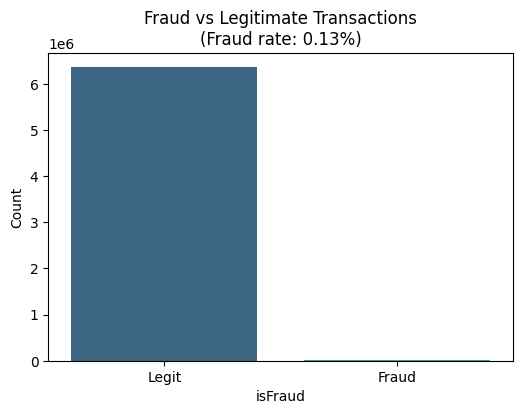

In [13]:
# === EDA Step 2: Fraud Distribution ===
import matplotlib.pyplot as plt
import seaborn as sns

fraud_counts = df["isFraud"].value_counts()
fraud_percent = df["isFraud"].mean() * 100

plt.figure(figsize=(6,4))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette="viridis")
plt.xticks([0,1], ["Legit", "Fraud"])
plt.ylabel("Count")
plt.title(f"Fraud vs Legitimate Transactions\n(Fraud rate: {fraud_percent:.2f}%)")
plt.show()


#Insight to note in your report: Class imbalance — e.g., fraud rate is very low, meaning we must handle imbalance in modeling.

/tmp/ipython-input-4221441854.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_by_type = df.groupby("type")["isFraud"].mean().sort_values(ascending=False) * 100
/tmp/ipython-input-4221441854.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_type.index, y=fraud_by_type.values, palette="coolwarm")


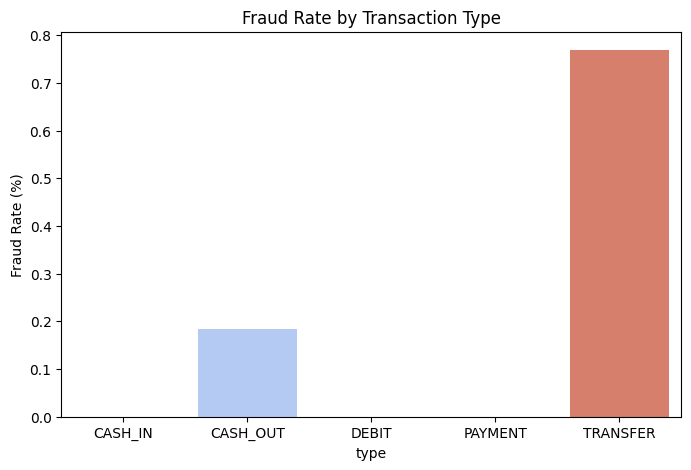

type
TRANSFER   0.7688
CASH_OUT   0.1840
CASH_IN    0.0000
DEBIT      0.0000
PAYMENT    0.0000
Name: isFraud, dtype: float64


In [14]:
# === EDA Step 3: Fraud by Transaction Type ===
fraud_by_type = df.groupby("type")["isFraud"].mean().sort_values(ascending=False) * 100
plt.figure(figsize=(8,5))
sns.barplot(x=fraud_by_type.index, y=fraud_by_type.values, palette="coolwarm")
plt.ylabel("Fraud Rate (%)")
plt.title("Fraud Rate by Transaction Type")
plt.show()

print(fraud_by_type)


/tmp/ipython-input-1419619641.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="isFraud", y="amount", data=df, showfliers=False, palette="mako")


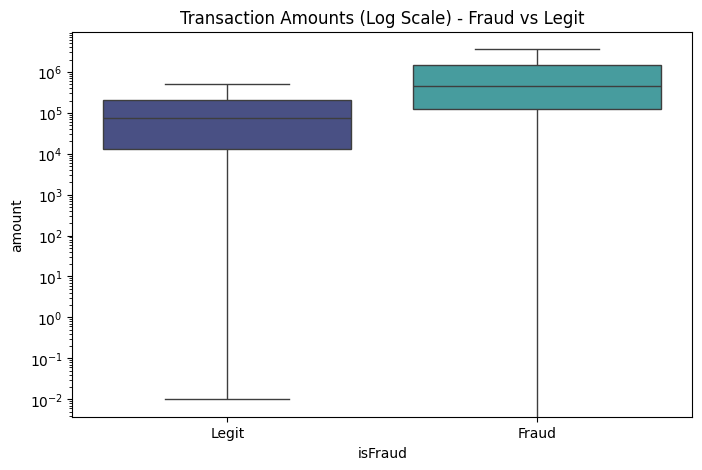

In [15]:
# === EDA Step 4: Amount Distribution ===
plt.figure(figsize=(8,5))
sns.boxplot(x="isFraud", y="amount", data=df, showfliers=False, palette="mako")
plt.yscale("log")
plt.xticks([0,1], ["Legit", "Fraud"])
plt.title("Transaction Amounts (Log Scale) - Fraud vs Legit")
plt.show()


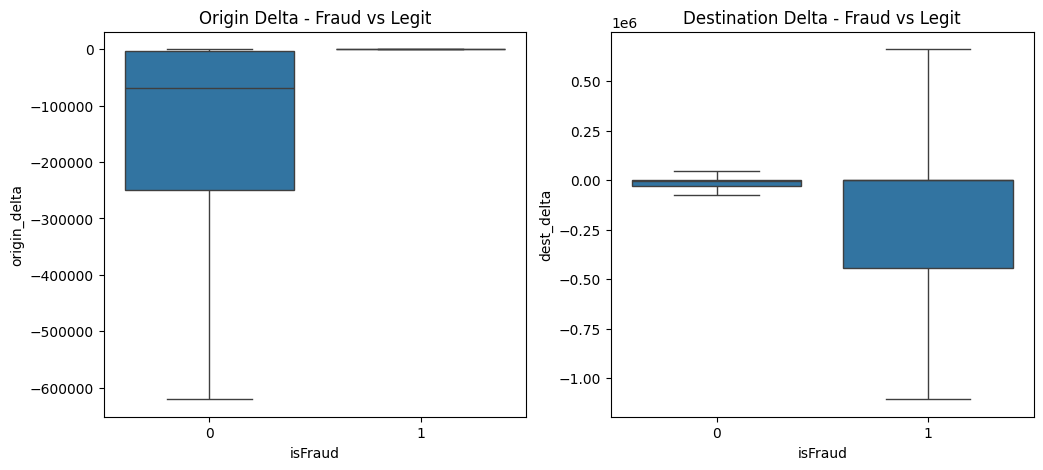

In [16]:
# === EDA Step 5: Balance Behavior ===
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.boxplot(x="isFraud", y="origin_delta", data=df, showfliers=False, ax=axes[0])
axes[0].set_title("Origin Delta - Fraud vs Legit")

sns.boxplot(x="isFraud", y="dest_delta", data=df, showfliers=False, ax=axes[1])
axes[1].set_title("Destination Delta - Fraud vs Legit")
plt.show()


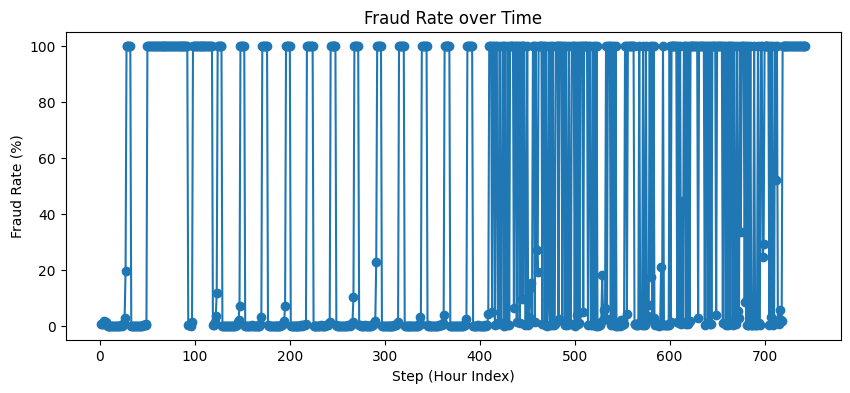

In [17]:
# === EDA Step 6: Time-based Fraud Analysis ===
fraud_time = df.groupby("step")["isFraud"].mean() * 100
plt.figure(figsize=(10,4))
plt.plot(fraud_time.index, fraud_time.values, marker='o')
plt.xlabel("Step (Hour Index)")
plt.ylabel("Fraud Rate (%)")
plt.title("Fraud Rate over Time")
plt.show()


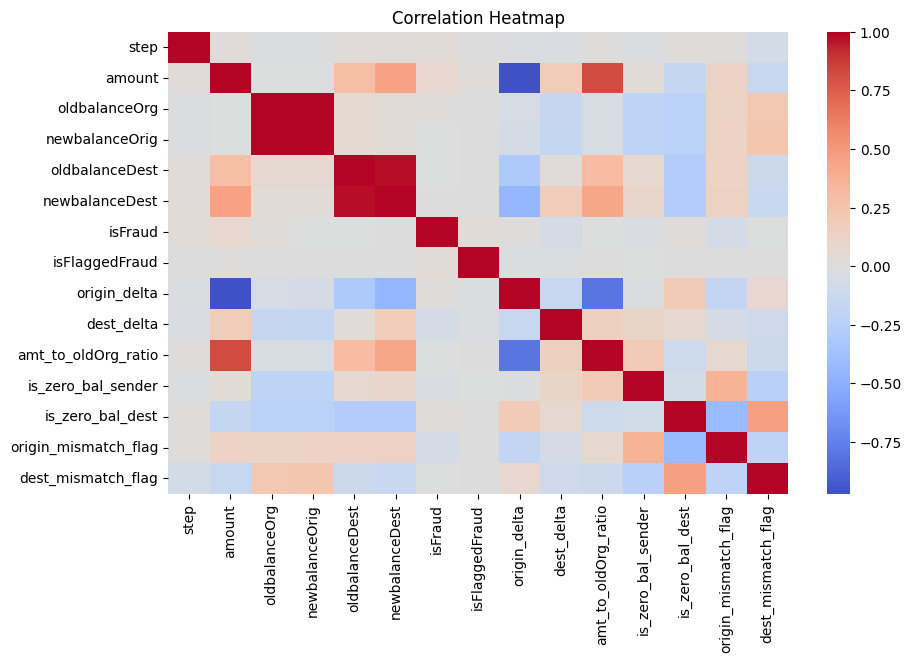

In [18]:
# === EDA Step 7: Correlation Heatmap (Numeric Only) ===
plt.figure(figsize=(10,6))
corr = df.select_dtypes(include=["float32","int8","int32"]).corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()


In [19]:


##Save each plot (right-click → Save Image As) into a plots/EDA folder.

##Copy the printed summary tables into your report & PPT.

##Write 2–3 lines of insight per plot


## TO SAVE ALL PLOTS INTO A SINGLE FOLDER DURING EDA

In [20]:
# Create a folder for plots & tables
import os
PLOT_DIR = "plots/EDA"
TABLE_DIR = "reports/EDA_tables"
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(TABLE_DIR, exist_ok=True)

# Simple helper to save the current matplotlib figure
def save_fig(name, dpi=200):
    import matplotlib.pyplot as plt
    path = os.path.join(PLOT_DIR, f"{name}.png")
    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print("🖼️ Saved:", path)


In [21]:
# Overview tables saved to CSV
overview = {
    "rows": [len(df)],
    "cols": [df.shape[1]],
    "fraud_rate": [df["isFraud"].mean()]
}
import pandas as pd
pd.DataFrame(overview).to_csv(os.path.join(TABLE_DIR, "overview.csv"), index=False)

df.dtypes.astype(str).reset_index().rename(columns={"index":"column",0:"dtype"}).to_csv(
    os.path.join(TABLE_DIR, "dtypes.csv"), index=False
)

df.isna().sum().reset_index().rename(columns={"index":"column",0:"missing"}).to_csv(
    os.path.join(TABLE_DIR, "missing_values.csv"), index=False
)

df.describe().to_csv(os.path.join(TABLE_DIR, "describe_numeric.csv"))
print("📄 Saved: overview, dtypes, missing_values, describe_numeric")


📄 Saved: overview, dtypes, missing_values, describe_numeric


🖼️ Saved: plots/EDA/01_fraud_distribution.png


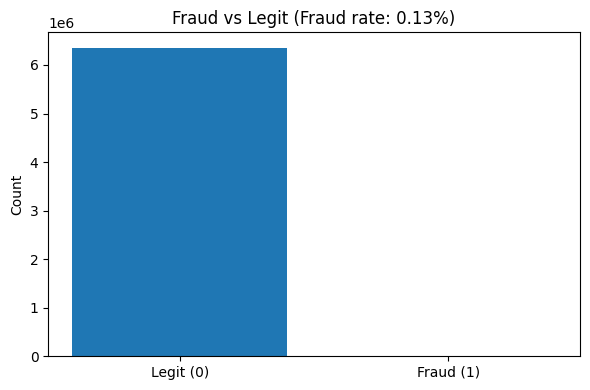

In [22]:
import matplotlib.pyplot as plt

counts = df["isFraud"].value_counts().sort_index()
labels = ["Legit (0)", "Fraud (1)"]

plt.figure(figsize=(6,4))
plt.bar(labels, counts.values)
plt.title(f"Fraud vs Legit (Fraud rate: {df['isFraud'].mean()*100:.2f}%)")
plt.ylabel("Count")
save_fig("01_fraud_distribution")
plt.show()


/tmp/ipython-input-2265225411.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_by_type = df.groupby("type")["isFraud"].mean().sort_values(ascending=False)*100


🖼️ Saved: plots/EDA/02_fraud_rate_by_type.png


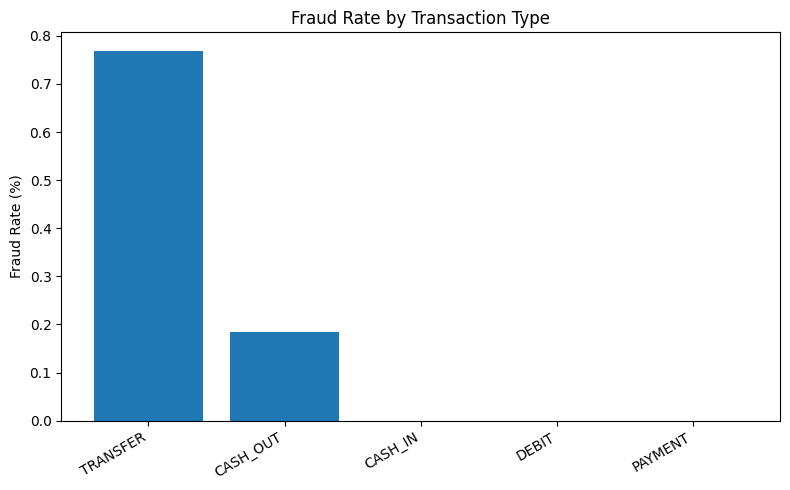

In [23]:
fraud_by_type = df.groupby("type")["isFraud"].mean().sort_values(ascending=False)*100
fraud_by_type.to_csv(os.path.join(TABLE_DIR, "fraud_rate_by_type.csv"))

plt.figure(figsize=(8,5))
plt.bar(fraud_by_type.index.astype(str), fraud_by_type.values)
plt.xticks(rotation=30, ha="right")
plt.ylabel("Fraud Rate (%)")
plt.title("Fraud Rate by Transaction Type")
save_fig("02_fraud_rate_by_type")
plt.show()


/tmp/ipython-input-4231349858.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([np.log10(data_legit), np.log10(data_fraud)], labels=["Legit", "Fraud"], showfliers=False)


🖼️ Saved: plots/EDA/03_amount_boxplot_log.png


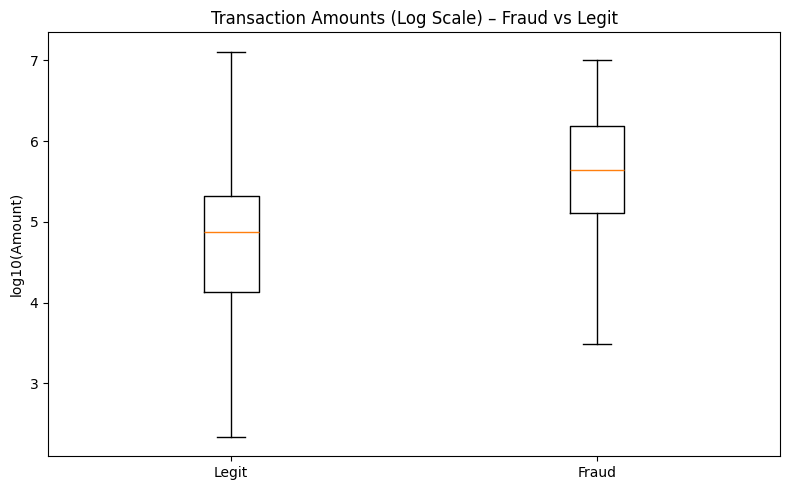

In [24]:
# Boxplot via matplotlib (no seaborn)
import numpy as np

data_legit = df.loc[df["isFraud"]==0, "amount"].clip(lower=0.01)
data_fraud = df.loc[df["isFraud"]==1, "amount"].clip(lower=0.01)

plt.figure(figsize=(8,5))
plt.boxplot([np.log10(data_legit), np.log10(data_fraud)], labels=["Legit", "Fraud"], showfliers=False)
plt.ylabel("log10(Amount)")
plt.title("Transaction Amounts (Log Scale) – Fraud vs Legit")
save_fig("03_amount_boxplot_log")
plt.show()


/tmp/ipython-input-3510504944.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df.loc[df["isFraud"]==0, "origin_delta"],


🖼️ Saved: plots/EDA/04_origin_delta_box.png


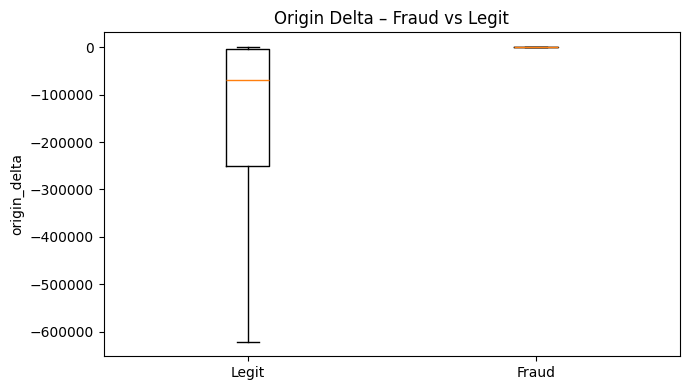

/tmp/ipython-input-3510504944.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df.loc[df["isFraud"]==0, "dest_delta"],


🖼️ Saved: plots/EDA/05_dest_delta_box.png


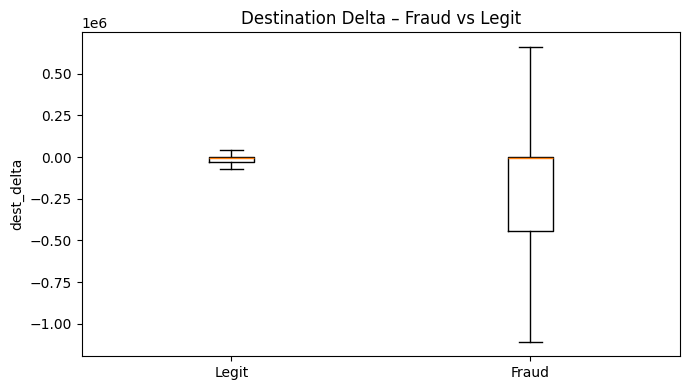

In [25]:
# Origin delta
plt.figure(figsize=(7,4))
plt.boxplot([df.loc[df["isFraud"]==0, "origin_delta"],
             df.loc[df["isFraud"]==1, "origin_delta"]],
            labels=["Legit","Fraud"], showfliers=False)
plt.title("Origin Delta – Fraud vs Legit")
plt.ylabel("origin_delta")
save_fig("04_origin_delta_box")
plt.show()

# Destination delta
plt.figure(figsize=(7,4))
plt.boxplot([df.loc[df["isFraud"]==0, "dest_delta"],
             df.loc[df["isFraud"]==1, "dest_delta"]],
            labels=["Legit","Fraud"], showfliers=False)
plt.title("Destination Delta – Fraud vs Legit")
plt.ylabel("dest_delta")
save_fig("05_dest_delta_box")
plt.show()


🖼️ Saved: plots/EDA/06_fraud_rate_over_time.png


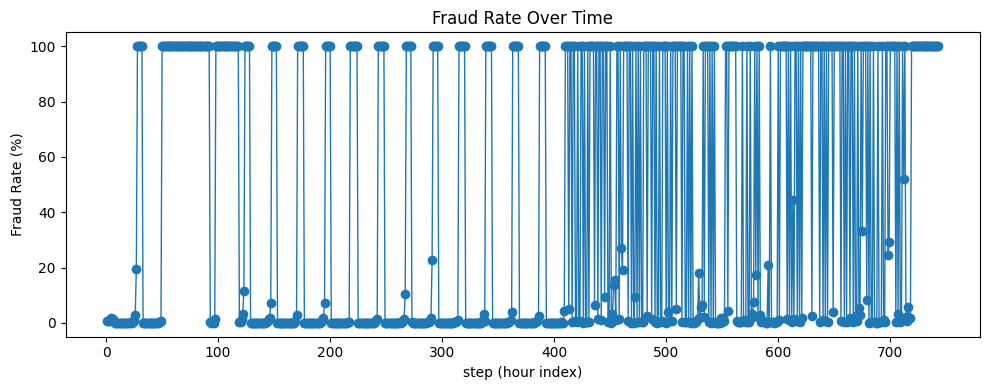

In [26]:
fraud_time = df.groupby("step")["isFraud"].mean()*100

plt.figure(figsize=(10,4))
plt.plot(fraud_time.index, fraud_time.values, marker="o", linewidth=1)
plt.xlabel("step (hour index)")
plt.ylabel("Fraud Rate (%)")
plt.title("Fraud Rate Over Time")
save_fig("06_fraud_rate_over_time")
plt.show()

fraud_time.to_csv(os.path.join(TABLE_DIR, "fraud_rate_over_step.csv"))


🖼️ Saved: plots/EDA/07_corr_heatmap_numeric.png


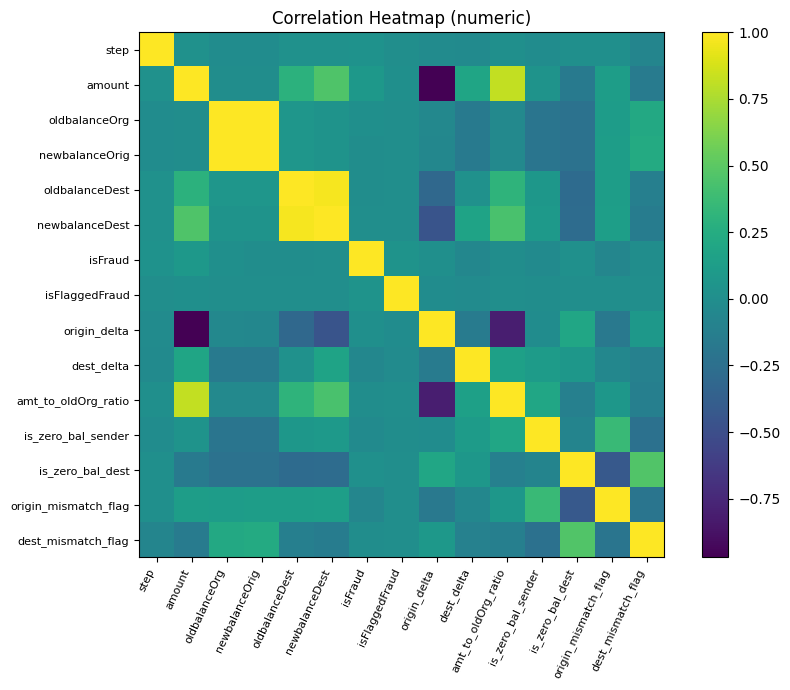

In [27]:
# Build a simple heatmap with matplotlib (no seaborn)
num_cols = df.select_dtypes(include=["int8","int32","float32"]).columns
corr = df[num_cols].corr().values
labels = list(num_cols)

plt.figure(figsize=(9,7))
plt.imshow(corr, interpolation="nearest")
plt.colorbar()
plt.title("Correlation Heatmap (numeric)")
plt.xticks(range(len(labels)), labels, rotation=65, ha="right", fontsize=8)
plt.yticks(range(len(labels)), labels, fontsize=8)
save_fig("07_corr_heatmap_numeric")
plt.show()


In [28]:
findings = f"""
EDA Key Notes (to paste into report/PPT)
---------------------------------------
Fraud rate: {df['isFraud'].mean()*100:.4f}%

Top risky transaction types (by fraud rate %):
{(df.groupby('type')['isFraud'].mean().sort_values(ascending=False)*100).round(3).head(5).to_string()}

Amount distribution: Fraud vs Legit shows higher median/upper tail for fraud (see 03_amount_boxplot_log.png).

Balance anomalies:
- origin_delta and dest_delta differ between fraud and legit (see 04_ and 05_ plots).

Time trend:
- See 06_fraud_rate_over_time.png for periods with elevated rates.

Next steps:
- Engineer velocity features and device/account change flags.
- Model with class-imbalance handling (class weights/SMOTE).
"""
out_path = os.path.join(TABLE_DIR, "eda_findings_scaffold.txt")
with open(out_path, "w") as f:
    f.write(findings)
print("📝 Saved:", out_path)
print(findings)


📝 Saved: reports/EDA_tables/eda_findings_scaffold.txt

EDA Key Notes (to paste into report/PPT)
---------------------------------------
Fraud rate: 0.1291%

Top risky transaction types (by fraud rate %):
type
TRANSFER   0.7690
CASH_OUT   0.1840
CASH_IN    0.0000
DEBIT      0.0000
PAYMENT    0.0000

Amount distribution: Fraud vs Legit shows higher median/upper tail for fraud (see 03_amount_boxplot_log.png).

Balance anomalies:
- origin_delta and dest_delta differ between fraud and legit (see 04_ and 05_ plots).

Time trend:
- See 06_fraud_rate_over_time.png for periods with elevated rates.

Next steps:
- Engineer velocity features and device/account change flags.
- Model with class-imbalance handling (class weights/SMOTE).



/tmp/ipython-input-4221174181.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  {(df.groupby('type')['isFraud'].mean().sort_values(ascending=False)*100).round(3).head(5).to_string()}


##REFERNCE BLOCK- USE FOR ALL THE PLOTS LISTED ABOVE

In [29]:
# === Save Helper Block (Reference) ===
import os
PLOT_DIR = "plots/EDA"
TABLE_DIR = "reports/EDA_tables"
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(TABLE_DIR, exist_ok=True)

def save_fig(name, dpi=200):
    import matplotlib.pyplot as plt
    path = os.path.join(PLOT_DIR, f"{name}.png")
    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print("🖼️ Saved:", path)


Perfect — now we can turn that into your **report-ready** and **PPT-ready** EDA Step 1 write-up.

---

## **Report – EDA Step 1: Dataset Overview**

The processed dataset contains **6,362,620 transactions** and **19 columns** after ingestion and feature engineering. These columns include raw transaction attributes, engineered fraud indicators, and time-derived variables.

**Data Types & Memory Optimization:**
Categorical identifiers (`type`, `nameOrig`, `nameDest`) are stored as `category` type, numerical values as `float32`, and binary flags as `int8` to optimise memory usage. This is critical for handling millions of rows in an interactive environment.

**Missing Values:**
No missing values were found in any column, ensuring the dataset is complete for analysis.

**Statistical Highlights:**

* **Transaction Amounts:** Range from **\$0** to **\$92.45 M**, median **\$74.87 K**.
* **Sender Balances:** Median `oldbalanceOrg` is **\$14.2 K**, but 33% of senders start with zero balance (`is_zero_bal_sender` mean = 0.3304).
* **Recipient Balances:** Median `oldbalanceDest` is **\$132.7 K**, but 42.5% of recipients have zero starting balance (`is_zero_bal_dest` mean = 0.4250).
* **Derived Features:**

  * Large negative medians for `origin_delta` and `dest_delta` suggest common balance mismatches.
  * High average `origin_mismatch_flag` (0.786) and `dest_mismatch_flag` (0.602) indicate many transactions do not reconcile perfectly.
  * `amt_to_oldOrg_ratio` shows extreme outliers, reflecting very large transfers relative to account size.
* **Fraud Label Distribution:** Mean `isFraud` = 0.0013 (\~0.13%), confirming significant class imbalance.

These statistics confirm that the dataset is both large and clean, with several engineered features already hinting at potential fraud patterns (e.g., zero balances, mismatched deltas).

---

## **PPT Slide – Dataset Overview (Condensed)**

**Dataset Overview**

* **Rows:** 6.36 M | **Columns:** 19
* **No missing values** – complete dataset
* **Optimised data types** for large-scale processing
* **Amount range:** \$0 – \$92.45 M | Median: \$74.87 K
* **Zero balances:** 33% senders, 42.5% recipients start at 0
* **Mismatch flags:** Origin = 78.6%, Dest = 60.2%
* **Fraud rate:** 0.13% – strong class imbalance
* Engineered features for fraud detection: balance deltas, ratio metrics, mismatch & zero-balance flags

---


